# Can we predict who would've survived the Tatanic?

### So what data we have for learning (aka Data Dictionary)

- survival: passenger-survival-status(0 = No, 1 = Yes)
- pclass: Ticket class(1 = 1st class, 2 = 2nd class, 3 = 3rd class)
    * 1st = Upper
    * 2nd = Middle
    * 3rd = Lower
- sex: male or female
- age: age in years
- sibsp: The dataset defines family relations in this way...
    * Sibling = brother, sister, stepbrother, stepsister
    * Spouse = husband, wife (mistresses and fiancés were ignored)
- parch: The dataset defines family relations in this way...
    * Parent = mother, father
    * Child = daughter, son, stepdaughter, stepson
    * Some children travelled only with a nanny, therefore parch=0 for them.
- ticket: Ticket Number
- fare: Passenger Fare
- embarked: Port of Embarkation
    * C = Cherbourg, Q = Queenstown, S = Southampton

In [9]:
# Import Dependencies
%matplotlib inline

# Start Python Imports
import math, time, random, datetime

# Data Manipulation
import numpy as np
import pandas as pd

# Data Visulization
import matplotlib.pyplot as plt
# import missingno
import seaborn as sns
plt.style.use('seaborn-whitegrid')

# Preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize

# Machine Learning
# import catboost
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn import tree, model_selection, metrics, preprocessing, linear_model
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
# from catboost import CatBoostClassifier, Pool, cv


# Let's ignore all warnings
import warnings
warnings.filterwarnings('ignore')

### Loading Data

In [10]:
# Import train & test data
train = pd.read_csv('titanic-dataset/train.csv') # train data
test = pd.read_csv('titanic-dataset/test.csv') # test data
gender_submission = pd.read_csv('titanic-dataset/gender_submission.csv') # example of what a submission should look like

In [11]:
# View the train data
train.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


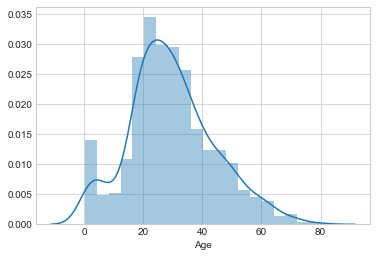

In [12]:
sns.distplot(train.Age)

In [13]:
# View test Data
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [14]:
# View the example of submission dataframe
gender_submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


### Now Let's Find the no of missing values in our train data

In [15]:
train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [16]:
train.shape

(891, 12)

So there are 2 columns having missing values

#### To perform our data analysis, let's create two new dataframes

We'll create one for exploring discretised continuous variables (continuous variables which have been sorted into some kind of category) and another for exploring continuous variables.

In [17]:
df_bin = pd.DataFrame() # for discretised continuous variables
df_con = pd.DataFrame() # for continuous variables

### What datatypes are in the dataframe?

As a general rule of thumb, features with a datatype of object could be considered categorical features. And those which are floats or  int (numbers) could be considered numerical features.

However, as we dig deeper, er might fing features which numerical may actually be categorical.

The goal for the nexte few steps is to figure our how best to process the cata so our machine learning model can learn from it.

Ideally, all the features will be encoded into a numerical values of some kind.

In [18]:
# Different data types in the dataset
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

## Let's explore each feature Individually

we'll go through each column iteratively and see which ones to use in our first models. Some may need more preprossing than others to get ready

In [19]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Target Feature: Survived

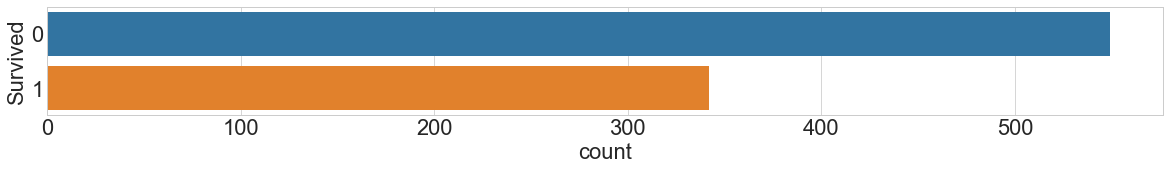

In [20]:
# How many people survived?

# Set label size
plt.rcParams.update({'font.size': 22})

# Plot
fig ,ax = plt.subplots(figsize=(20, 2))
sns.countplot(y=train.Survived, data=train, ax=ax);

In [21]:
# Let's add this to our subset dataframes
df_bin['Survived'] = train['Survived']
df_con['Survived'] = train['Survived']

In [22]:
df_bin.head()

,Survived
0,0
1,1
2,1
3,1
4,0


In [23]:
df_con.head()

,Survived
0,0
1,1
2,1
3,1
4,0


### Feature Pclass

**Let's plot the Pclass (distribution of tickets)**

We wil look at the distribution of each feature first if we can to understand what kind of speard there there is across the dataset.

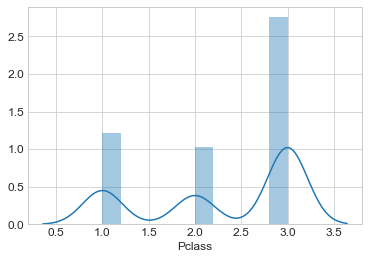

In [24]:
plt.rcParams.update({'font.size': 12})
sns.distplot(train.Pclass)

In [25]:
# find missing values in Pclass
train.Pclass.isna().sum()

0

In [26]:
df_bin['Pclass'] = train['Pclass']
df_con['Pclass'] = train['Pclass']

### Feature: Name

In [27]:
# How many different names are there?
train.Name.value_counts()

Robbins, Mr. Victor             1
Markoff, Mr. Marin              1
West, Mr. Edwy Arthur           1
Coxon, Mr. Daniel               1
Hood, Mr. Ambrose Jr            1
                               ..
Wright, Mr. George              1
Murphy, Miss. Margaret Jane     1
Lindqvist, Mr. Eino William     1
Kimball, Mr. Edwin Nelson Jr    1
Moran, Mr. James                1
Name: Name, Length: 891, dtype: int64

So here we can see every row has unique name. This is eqivalent to the passenger ID. But name could be used differently. 

Can  you think of ways you could reduce the number of different names? Or create new feature out the the names.

**Note:** Because of so many different names and to keep this EDA fast, we won't move  forward using name variable.

### Feature: Sex

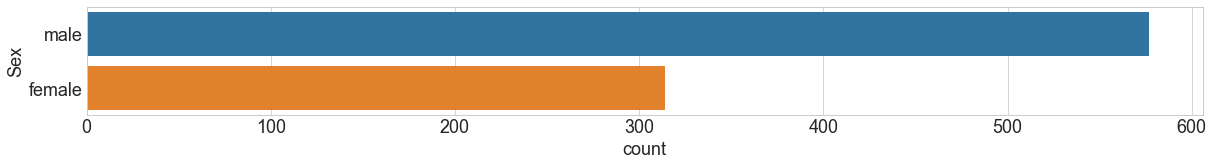

In [28]:
# Let's view the distuibution of Sex Column?

plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(20, 2))
sns.countplot(y=train.Sex, data=train)

In [29]:
# Let's check the missing values in the Sex column\
train.Sex.isna().sum()

0

In [30]:
# add sex to the subset dataframe
df_bin['Sex'] = train['Sex']
df_bin['Sex'] = np.where(df_bin['Sex'] == 'female', 1, 0) # change sex to 0 for male and 1 for female
df_con['Sex'] = train['Sex']

In [31]:
df_bin['Sex']

0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    1
889    0
890    0
Name: Sex, Length: 891, dtype: int32

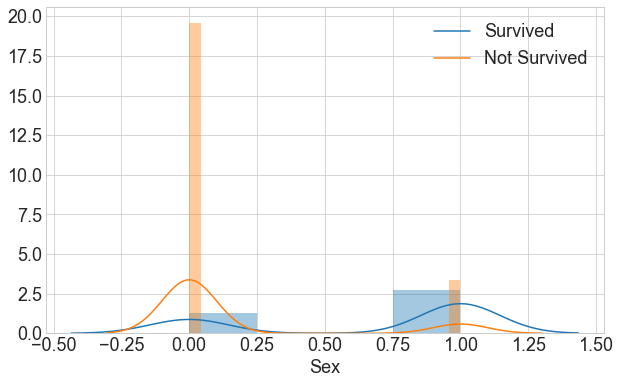

In [32]:
# How does the Sex variable look caompared to Survival?
# WE can see this both are binarys.

fig = plt.figure(figsize=(10, 6))
sns.distplot(df_bin[df_bin.Survived == 1]['Sex'], kde_kws={'label': 'Survived'})
sns.distplot(df_bin[df_bin.Survived == 0]['Sex'], kde_kws={'label': 'Not Survived'});

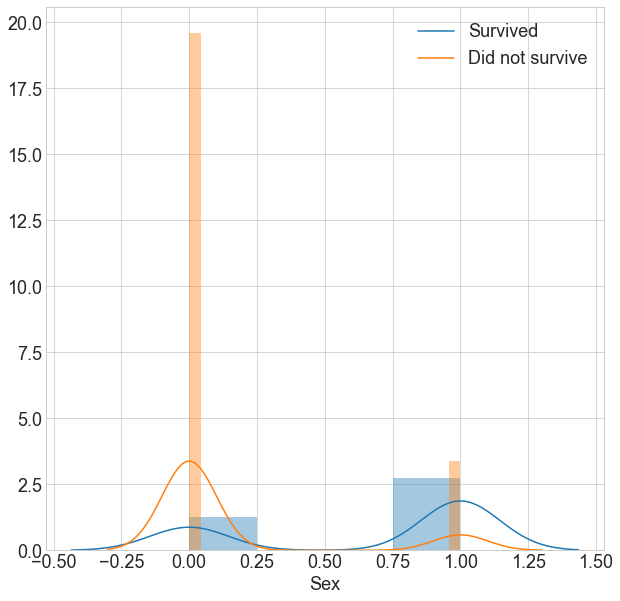

In [33]:
fig = plt.figure(figsize=(10, 10))
sns.distplot(df_bin.loc[df_bin['Survived'] == 1]['Sex'], kde_kws={'label': 'Survived'});
sns.distplot(df_bin.loc[df_bin['Survived'] == 0]['Sex'], kde_kws={'label': 'Did not survive'});

**Not many people survived. But of those who did, more were female.**

### Feature: Age

In [34]:
# how many missing values does age have?
train.Age.isna().sum()

177

Out of a total 891 rows, that's almost 177 (one quarter) of the dataset is missing.

* What would you do with these missing values?
* Could you replace them with these missing values?
* Or would you get rid of them completely?


In [35]:
# Once the Age values have been fixed up, we can add them to our sub dataframes.
# df_bin['Age'] = pd.cut(train['Age'], 10) # bucketed/binned into different categories
# df_con['Age'] = train['Age'] # non-bucketed

**Function to create count and distribution visulizations**

In [36]:
def plot_count_dist(data, bin_df, label_column,target_column ,figsize=(20, 5), use_bin_df=False):
    """
    Function to plot count and distributions of the label varible and the target varible side by side.
    
    ::param_data:: = target dataframe
    ::param_bin_df:: = binned dataframe for countplot
    ::param_label_column:: = binary labelled column
    ::param_target_column:: = column you want to view counts and distributions
    ::param_figszize:: = size of figure (weight, height)
    ::param_use_bin_df:: = whether or not to use the bin_off,  default = False
    """
    if use_bin_df:
        plt.rcParams.update({'font.size': 12})
        fig = plt.figure(figsize=figsize)
        plt.subplot(1, 2, 1)
        sns.countplot(y=target_column, data=bin_df)
        plt.subplot(1, 2, 2)
        sns.distplot(data[data[label_column] == 1][target_column],
                    kde_kws={"label": "Survived"})
        sns.distplot(data[data[label_column] == 0][target_column],
                    kde_kws={"label": "Did not Survived"});
        
        
    else:
        fig = plt.figure(figsize=figsize)
        plt.subplot(1, 2, 1)
        sns.countplot(y=target_column, data=data)
        plt.subplot(1, 2, 2)
        sns.distplot(data[data[label_column] == 1][target_column],
                    kde_kws={'label': 'Survived'})
        sns.distplot(data[data[label_column] == 0][target_column],
                    kde_kws={'label': 'Did not Survived'})
        

### Feature: SipSp

In [37]:
# How many missing values does Sibsp have?
train.SibSp.isna().sum()

0

In [38]:
# What values are there?
train.SibSp.value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

In [39]:
# Add SibSp to subset dataframe
df_bin['SibSp'] = train['SibSp']
df_con['SibSp'] = train['SibSp']

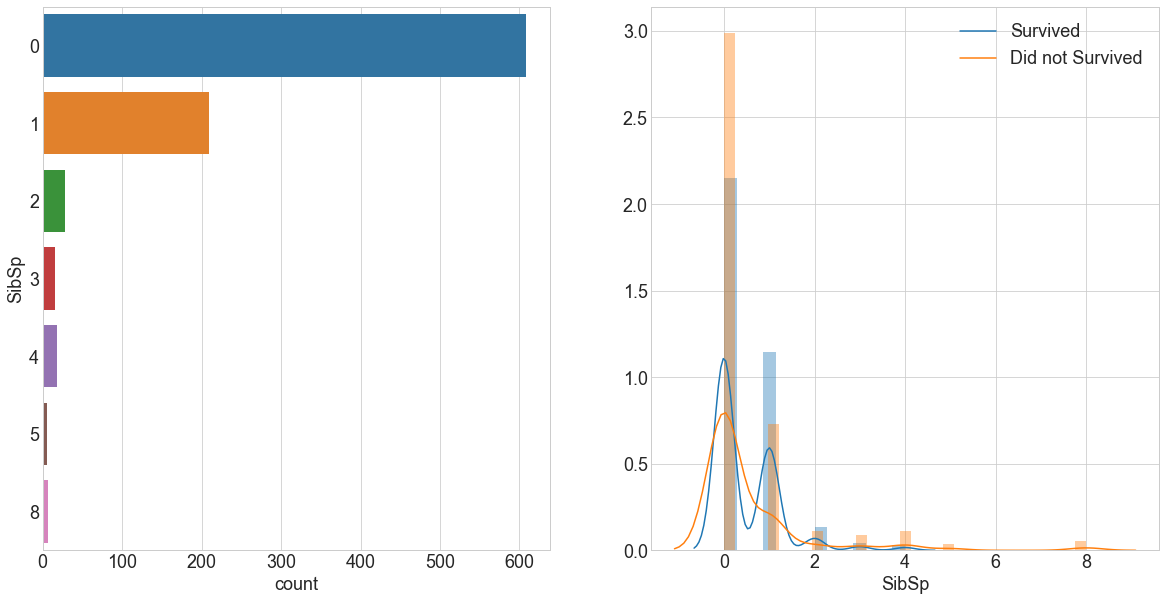

In [40]:
# visualize the counts of SibSp and the distribution of the values
# against Survived
plot_count_dist(
    train, 
    bin_df=df_bin,
    label_column='Survived',
    target_column='SibSp',
    figsize=(20, 10)
)

### Feature: Parch

In [41]:
# How many missing values does Parch have?
train.Parch.isna().sum()

0

In [42]:
# What values are there?
train.Parch.value_counts()

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

In [43]:
# Add Parch to subset dataframes
df_bin['Parch'] = train['Parch']
df_con['Parch'] = train['Parch']

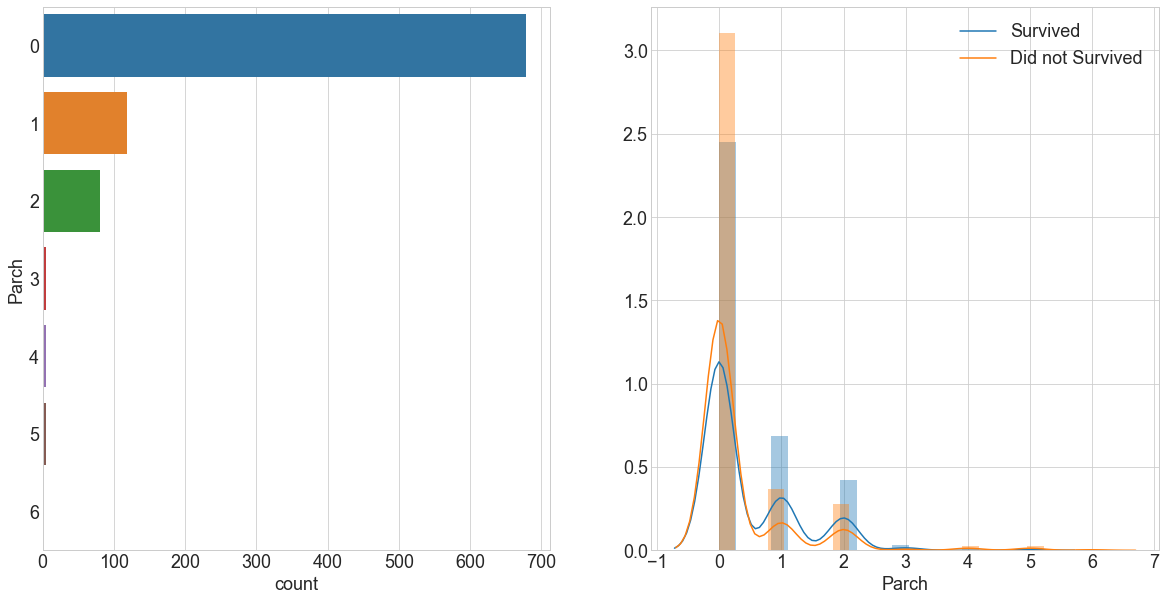

In [44]:
# Visualize the counts of Parch and the distribution of the values
# aganist Survived
plot_count_dist(
    train,
    bin_df=df_bin,
    label_column='Survived',
    target_column='Parch',
    figsize=(20, 10),
)

In [45]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [46]:
df_con.head()

,Survived,Pclass,Sex,SibSp,Parch
0,0,3,male,1,0
1,1,1,female,1,0
2,1,3,female,0,0
3,1,1,female,1,0
4,0,3,male,0,0


### Feature: Ticket

In [47]:
# missing values in Ticket columns
train.Ticket.isna().sum()

0

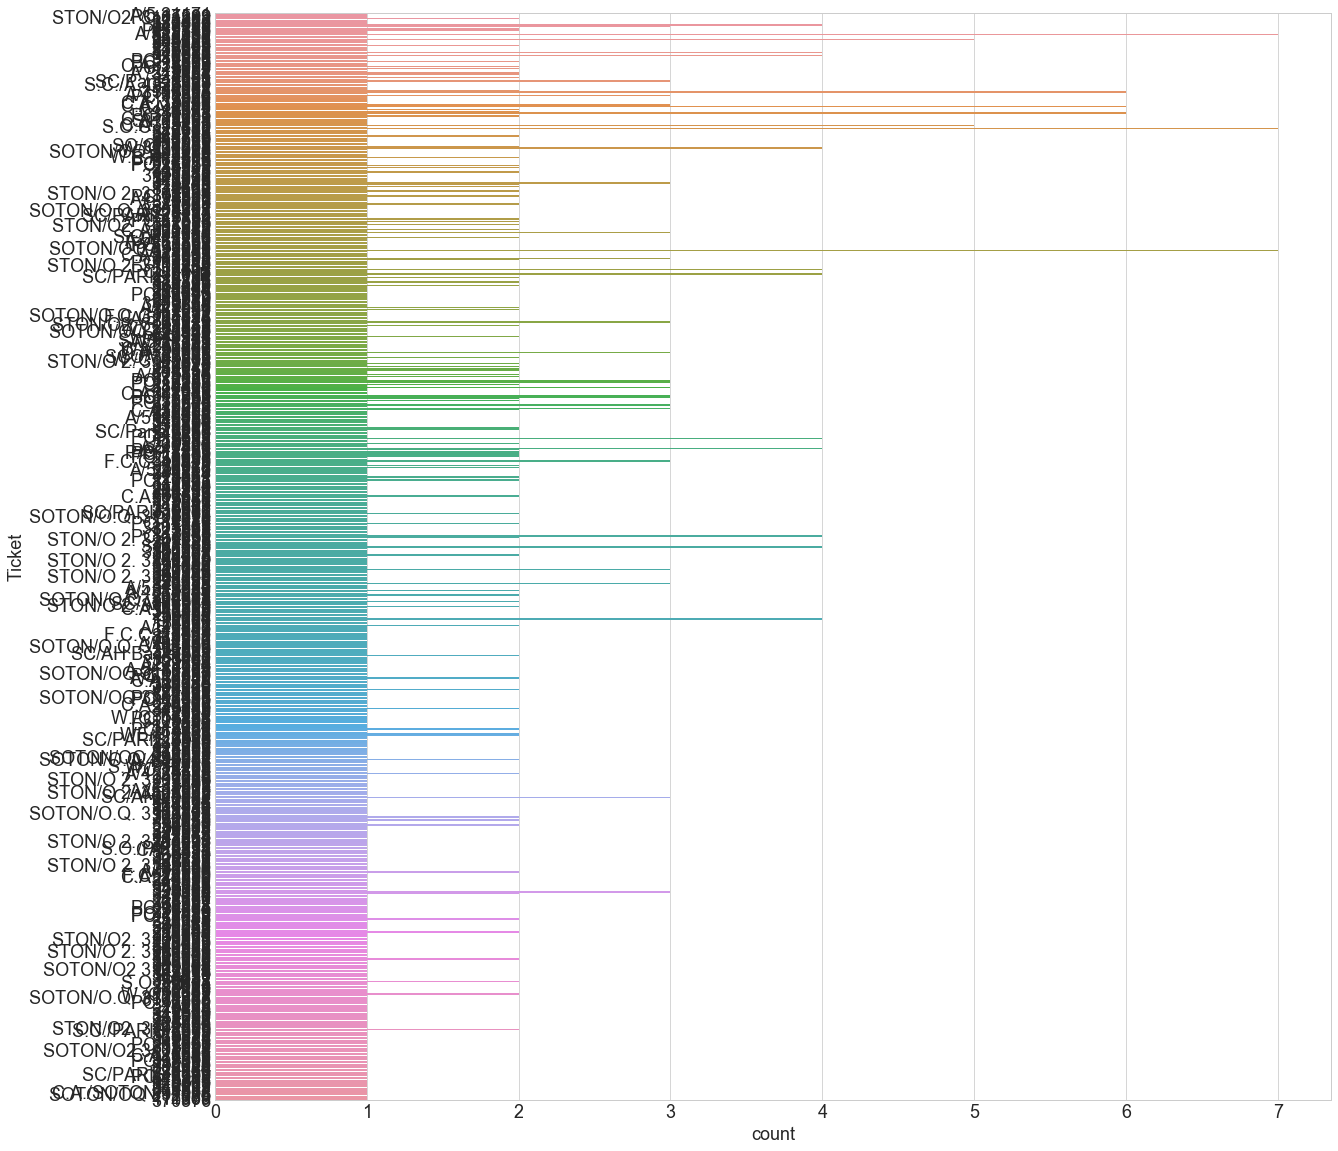

In [48]:
plt.figure(figsize=(20, 20))
sns.countplot(y="Ticket", data=train);

In [49]:
# The upper one does'nt look good
# Let's see it without plot
train.Ticket.value_counts()

347082      7
1601        7
CA. 2343    7
3101295     6
347088      6
           ..
28664       1
36209       1
248706      1
29104       1
250653      1
Name: Ticket, Length: 681, dtype: int64

In [50]:
# How many unique kinds of Ticket are there?
print(f"There are {len(train.Ticket.unique())} unique Ticket Values ")

There are 681 unique Ticket Values 


So there total 681 total unique values (too many), So we don't use Ticket in our subset dataframes.

There may be some way to this down.

**Challenge:** How could you reduce the Ticket feature? Is it even possible?

**Hint:**  It may be similar to what you could do with name.


### Feature: Fare

In [51]:
# How many missing values does Fare are there?
train.Fare.isna().sum()

0

In [52]:
# what kind of data in Fare?
train.Fare.dtype

dtype('float64')

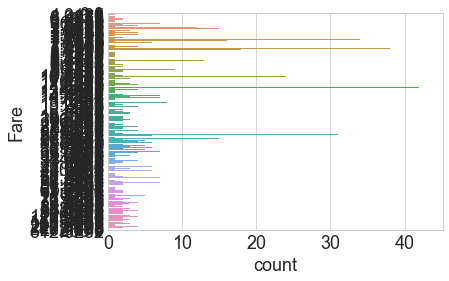

In [53]:
# How many different values of Fare are there
sns.countplot(y='Fare', data=train)

In [54]:
# So it is not visible right?
# Let's try another one
train.Fare.value_counts()

8.0500     43
13.0000    42
7.8958     38
7.7500     34
26.0000    31
           ..
8.4583      1
9.8375      1
8.3625      1
14.1083     1
17.4000     1
Name: Fare, Length: 248, dtype: int64

In [55]:
# finding unique values in the Fare
len(train.Fare.unique())

248

Beacause Fare is a float (number) let's add it as it is our continuous sub dataframe but to add it to our categorical sub dataframe, we'll cut it to bins.

In [56]:
# add Fare to sub dataframes
df_con['Fare'] = train.Fare
df_bin['Fare'] = pd.cut(train.Fare, bins=5) # discretised

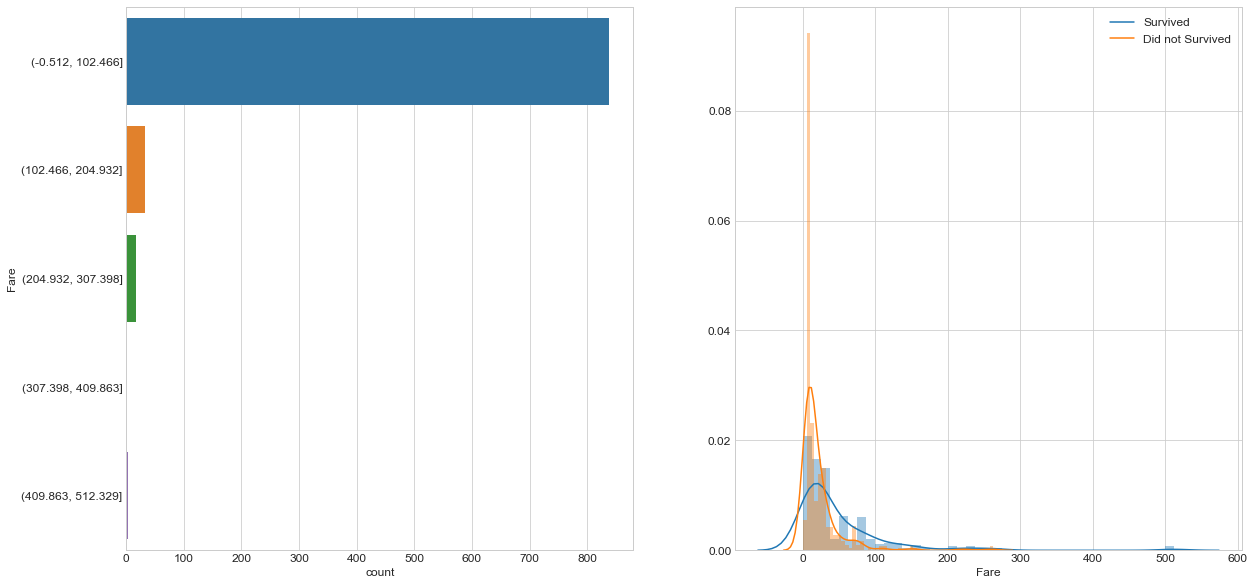

In [57]:
plot_count_dist(data=train,
               bin_df=df_bin,
               label_column='Survived', 
               target_column='Fare',
               figsize=(20, 10),
               use_bin_df=True)

**challenge:** How would ypu change tha Fare bins.

### Feature: Cabin

In [58]:
# How many missing values does Cabin have?
train.Cabin.isna().sum()

687

In [59]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [60]:
# What do the Cabin values look like?
train.Cabin.value_counts()

B96 B98        4
C23 C25 C27    4
G6             4
E101           3
F2             3
              ..
F G63          1
E77            1
E10            1
C90            1
A5             1
Name: Cabin, Length: 147, dtype: int64

Since there are too many missing values, we won't use Cabin for our initial models and won't add it our sub dataframe.

But how could you modify cabin to be more usable?

What could you do about the missing values?

### Features: Embarked

In [61]:
# missing value info
train.Embarked.isna().sum()

2

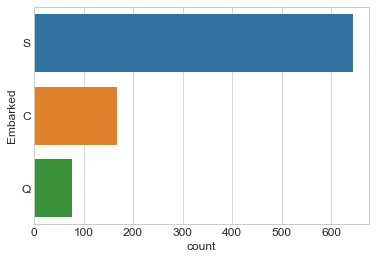

In [62]:
# Let's plot them
sns.countplot(y=train.Embarked, data=train)

**How can we deal with the 2 missing values of Embarked?**

One option is to drop the two rows which don't have an Embarked value.

Another option would be to randomly assign a value of C, Q or S to each row.

For now, we will remove those rows.

In [63]:
# Add Embarked to sub dataframes
df_bin['Embarked'] = train.Embarked
df_con['Embarked'] = train.Embarked

In [64]:
# Remove Embarked rows which are missing values
print(len(df_con))
df_con = df_con.dropna(subset=['Embarked'])
df_bin = df_bin.dropna(subset=['Embarked'])
print(len(df_con))

891
889


We're removed the two rows with missing values for Embarked,now we can add Embarked to our sub datframes

## Feature Encoding 

Now we have our two sub dataframes ready. We can encode the  features so they're ready to be used with our machine learning models.

We will encode our binned dataframe (df_bin) wiht One-Hot Encoder and our continuous dataframe (df_con) with Column Transfromer from Scikit-Learn.

In [65]:
df_bin.head()

,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked
0,0,3,0,1,0,"(-0.512, 102.466]",S
1,1,1,1,1,0,"(-0.512, 102.466]",C
2,1,3,1,0,0,"(-0.512, 102.466]",S
3,1,1,1,1,0,"(-0.512, 102.466]",S
4,0,3,0,0,0,"(-0.512, 102.466]",S


In [66]:
bin_columns_list = df_bin.columns.to_list()
bin_columns_list.remove('Survived')
df_bin_enc = pd.get_dummies(df_bin, columns=bin_columns_list)
df_bin_enc.head()

,Survived,Pclass_1,Pclass_2,Pclass_3,Sex_0,Sex_1,SibSp_0,SibSp_1,SibSp_2,SibSp_3,...,Parch_5,Parch_6,"Fare_(-0.512, 102.466]","Fare_(102.466, 204.932]","Fare_(204.932, 307.398]","Fare_(307.398, 409.863]","Fare_(409.863, 512.329]",Embarked_C,Embarked_Q,Embarked_S
0,0,0,0,1,1,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,1
1,1,1,0,0,0,1,0,1,0,0,...,0,0,1,0,0,0,0,1,0,0
2,1,0,0,1,0,1,1,0,0,0,...,0,0,1,0,0,0,0,0,0,1
3,1,1,0,0,0,1,0,1,0,0,...,0,0,1,0,0,0,0,0,0,1
4,0,0,0,1,1,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,1


In [67]:
# Now let's check the df_con()
df_con.head()

,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked
0,0,3,male,1,0,7.2500,S
1,1,1,female,1,0,71.2833,C
2,1,3,female,0,0,7.9250,S
3,1,1,female,1,0,53.1000,S
4,0,3,male,0,0,8.0500,S


In [68]:
con_clumns = ['Pclass', 'Sex', 'Embarked']
df_con_enc = pd.get_dummies(df_con, columns=con_clumns)
df_con_enc.head()

,Survived,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,1,0,7.2500,0,0,1,0,1,0,0,1
1,1,1,0,71.2833,1,0,0,1,0,1,0,0
2,1,0,0,7.9250,0,0,1,1,0,0,0,1
3,1,1,0,53.1000,1,0,0,1,0,0,0,1
4,0,0,0,8.0500,0,0,1,0,1,0,0,1


In [69]:
df_con_enc.shape

(889, 12)

## Start Building Machine learning Models

Now our data has been manipulating and coverted to numbers, we can run a series of different macchine learning algorithmsover it to find which yeild the results.

### Let's Seperate the data

In [70]:
# Select the dataframe we want to use first for predictions
selected_df = df_con_enc

In [71]:
# Now let's check the data
selected_df.head()

,Survived,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,1,0,7.2500,0,0,1,0,1,0,0,1
1,1,1,0,71.2833,1,0,0,1,0,1,0,0
2,1,0,0,7.9250,0,0,1,1,0,0,0,1
3,1,1,0,53.1000,1,0,0,1,0,0,0,1
4,0,0,0,8.0500,0,0,1,0,1,0,0,1


In [72]:
# It look good
# Now let's split the dataframe into data and labels
X_train = selected_df.drop('Survived', axis=1)
y_train = selected_df['Survived']

In [73]:
# check shape of our splited data
X_train.shape, y_train.shape

((889, 11), (889,))

In [74]:
# Let's check the X data
X_train.head()

,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,1,0,7.2500,0,0,1,0,1,0,0,1
1,1,0,71.2833,1,0,0,1,0,1,0,0
2,0,0,7.9250,0,0,1,1,0,0,0,1
3,1,0,53.1000,1,0,0,1,0,0,0,1
4,0,0,8.0500,0,0,1,0,1,0,0,1


### Define a Function to fit Machine Learning Algorithms

Since many of the algorithms we will use are from the sklearn library, they all take similer (practically the same) imputs ans produce similar outputs

To prevent writing code multiple times, we will functionise fitting the model and returning the accuracy scores.

In [75]:
# Fuctions that rums the requested alogorithm and returns the accuracy metrics

def fit_ml_algo(algo, X_train, y_train, cv):
    
    # One Pass
    model = algo.fit(X_train, y_train)
    acc = round(model.score(X_train, y_train) * 100, 2)
    
    # Cross Validation
    train_pred = model_selection.cross_val_predict(
        algo,
        X_train,
        y_train,
        cv=cv,
        n_jobs=-1
    )
    
    # Cross Validation Accuracy metric
    acc_cv = round(metrics.accuracy_score(y_train, train_pred) * 100, 2)
    
    return train_pred, acc, acc_cv

#### Now let's try different models,

### Logistic Rogression

In [76]:
start_time = time.time()
train_pred_log, acc_log, acc_cv_log = fit_ml_algo(LogisticRegression(),
                                        X_train,
                                        y_train,
                                        10)
log_time = (time.time() - start_time)
print(f"Accuracy: {acc_log}")
print(f"Accuracy 10 CV-Fold: {acc_cv_log}")
print(f"Running Time: {datetime.timedelta(seconds=log_time)}")

Accuracy: 79.98
Accuracy 10 CV-Fold: 79.42
Running Time: 0:00:02.208175


### K-Nearest Neighbours

In [77]:
# K-Nearest Neighbours
start_time = time.time()
train_pred_knn, acc_knn, acc_cv_knn = fit_ml_algo(KNeighborsClassifier(),
                                        X_train,
                                        y_train,
                                        10)
knn_time = (time.time() - start_time)
print(f"Accuracy: {acc_knn}")
print(f"Accuracy 10 CV-Fold: {acc_cv_knn}")
print(f"Running Time: {datetime.timedelta(seconds=knn_time)}")

Accuracy: 83.46
Accuracy 10 CV-Fold: 76.72
Running Time: 0:00:00.175982


### Gaussian Naive Bayes

In [78]:
start_time = time.time()
train_pred_gaussian, acc_gaussian, acc_cv_gaussian = fit_ml_algo(GaussianNB(),
                                        X_train,
                                        y_train,
                                        10)
gaussian_time = (time.time() - start_time)
print(f"Accuracy: {acc_gaussian}")
print(f"Accuracy 10 CV-Fold: {acc_cv_gaussian}")
print(f"Running Time: {datetime.timedelta(seconds=gaussian_time)}")

Accuracy: 78.52
Accuracy 10 CV-Fold: 77.95
Running Time: 0:00:00.061797


### Linear Support Vector Machine(SVC)

In [79]:
start_time = time.time()
train_pred_svc, acc_svc, acc_cv_svc = fit_ml_algo(LinearSVC(),
                                        X_train,
                                        y_train,
                                        10)
svc_time = (time.time() - start_time)
print(f"Accuracy: {acc_svc}")
print(f"Accuracy 10 CV-Fold: {acc_cv_svc}")
print(f"Running Time: {datetime.timedelta(seconds=svc_time)}")

Accuracy: 79.64
Accuracy 10 CV-Fold: 76.83
Running Time: 0:00:00.362513


### Stochastic Gradient Desent

In [80]:
start_time = time.time()
train_pred_sgd, acc_sgd, acc_cv_sgd = fit_ml_algo(SGDClassifier(),
                                        X_train,
                                        y_train,
                                        10)
sgd_time = (time.time() - start_time)
print(f"Accuracy: {acc_sgd}")
print(f"Accuracy 10 CV-Fold: {acc_cv_sgd}")
print(f"Running Time: {datetime.timedelta(seconds=sgd_time)}")

Accuracy: 75.7
Accuracy 10 CV-Fold: 72.33
Running Time: 0:00:00.063948


### Decision Tree Classifier

In [81]:
start_time = time.time()
train_pred_dt, acc_dt, acc_cv_dt = fit_ml_algo(DecisionTreeClassifier(),
                                        X_train,
                                        y_train,
                                        10)
dt_time = (time.time() - start_time)
print(f"Accuracy: {acc_dt}")
print(f"Accuracy 10 CV-Fold: {acc_cv_dt}")
print(f"Running Time: {datetime.timedelta(seconds=dt_time)}")

Accuracy: 92.46
Accuracy 10 CV-Fold: 80.31
Running Time: 0:00:00.072434


### Gradient Boost Trees

In [82]:
start_time = time.time()
train_pred_gbt, acc_gbt, acc_cv_gbt = fit_ml_algo(GradientBoostingClassifier(),
                                        X_train,
                                        y_train,
                                        10)
gbt_time = (time.time() - start_time)
print(f"Accuracy: {acc_gbt}")
print(f"Accuracy 10 CV-Fold: {acc_cv_gbt}")
print(f"Running Time: {datetime.timedelta(seconds=gbt_time)}")

Accuracy: 86.61
Accuracy 10 CV-Fold: 80.65
Running Time: 0:00:00.743219


## Model Results

Which model had the best Accuracy?

**Note:** We care most about cross-validation metrics beacause the metrics we get from .fit() can randomly score higher than usual.

#### Regular Accuracy Scores (Without CV)

In [83]:
models = pd.DataFrame({
    'Models' : ['K-Nearest Neighbours', 'Gaussion Naive Bayes',
               'Stochastic Gradient Decent', 'Linear SVC', 
                'Decision Tree', 'Gradient Boosting Trees',],
    'Score' : [acc_knn, acc_gaussian,
              acc_sgd, acc_svc,
              acc_dt, acc_gbt]
})
print("----Regular Accuracy Scores----")
models.sort_values(by='Score', ascending=False)

----Regular Accuracy Scores----


,Models,Score
4,Decision Tree,92.46
5,Gradient Boosting Trees,86.61
0,K-Nearest Neighbours,83.46
3,Linear SVC,79.64
1,Gaussion Naive Bayes,78.52
2,Stochastic Gradient Decent,75.70


#### Cross Validation Accuracy Scores

In [84]:
cv_models = pd.DataFrame({
    'Models' : ['K-Nearest Neighbours', 'Gaussion Naive Bayes',
               'Stochastic Gradient Decent', 'Linear SVC', 
                'Decision Tree', 'Gradient Boosting Trees',],
    'Score' : [acc_cv_knn, acc_cv_gaussian,
              acc_cv_sgd, acc_cv_svc,
              acc_cv_dt, acc_cv_gbt]
})
print("----Cross Validation Accuracy Scores----")
cv_models.sort_values(by='Score', ascending=False)

----Cross Validation Accuracy Scores----


,Models,Score
5,Gradient Boosting Trees,80.65
4,Decision Tree,80.31
1,Gaussion Naive Bayes,77.95
3,Linear SVC,76.83
0,K-Nearest Neighbours,76.72
2,Stochastic Gradient Decent,72.33


We can see from the table, the `Gradient Boosting Model` had the best Result. **Getting allmost 81% is pretty good**.

We'll pay more attention to the cross-validation figure.

Cross Validation is more robustt than just the `.fit()`models as it does multiple passes over the data instead of one.

**Because the `Gradient Boosting Trees` got the best results, we'll use it for the next steps.**

**Challenge:** How could you improve the `Gradient Boosting Model` more further.

## Tuning the hyper-parameter of `Gradient Boosting Model`

In [85]:
# Let's see the default params og Gradient Boosting Model

GradientBoostingClassifier().get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'presort': 'deprecated',
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [86]:
# Making a grid that contains all parameters that we are looking to tune.
para_grid = {
    'loss': ['deviance', 'exponential'],
    'learning_rate': [1, 0.05, 0.5, 0.25, 0.1, 0.01],
    'n_estimators': np.arange(0, 1000, 50),
    'max_depth': np.linspace(1, 32, 32),
    'min_samples_leaf': np.linspace(0.1, 0.5, 5),
    'min_samples_split': np.linspace(0.1, 1.0, 10),
    'max_features': list(range(1, train.shape[1]))
}
para_grid

{'loss': ['deviance', 'exponential'],
 'learning_rate': [1, 0.05, 0.5, 0.25, 0.1, 0.01],
 'n_estimators': array([  0,  50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600,
        650, 700, 750, 800, 850, 900, 950]),
 'max_depth': array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
        27., 28., 29., 30., 31., 32.]),
 'min_samples_leaf': array([0.1, 0.2, 0.3, 0.4, 0.5]),
 'min_samples_split': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 'max_features': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]}

In [87]:
# Let's turn paratmeter using RandomizedSearchCV
rs_gb = RandomizedSearchCV(
    estimator=GradientBoostingClassifier(),
    param_distributions=para_grid,
    n_iter=50,
    cv=10,
    verbose=True,
    random_state=42,
    n_jobs=-1,
)
rs_gb.fit(X_train, y_train)

Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 208 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 458 tasks      | elapsed:   38.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   41.6s finished


RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                        criterion='friedman_mse',
                                                        init=None,
                                                        learning_rate=0.1,
                                                        loss='deviance',
                                                        max_depth=3,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                   

In [88]:
# Now Let's Implement the GridSearchCV
#gs_gb = GridSearchCV(
#     estimator=GradientBoostingClassifier(),
#     param_grid=para_grid,
#     cv=10,
#     verbose=True,
# )
# gs_gb.fit(X_train, y_train) 

In [89]:
rs_gb.best_params_

{'n_estimators': 250,
 'min_samples_split': 0.2,
 'min_samples_leaf': 0.1,
 'max_features': 11,
 'max_depth': 31.0,
 'loss': 'exponential',
 'learning_rate': 0.05}

In [90]:
# Getting our test data Ready

test_enc = test
test_enc = test_enc.drop(['Name', 'Cabin', 'PassengerId', 'Ticket', 'Age'], axis=1)
test_enc

,Pclass,Sex,SibSp,Parch,Fare,Embarked
0,3,male,0,0,7.8292,Q
1,3,female,1,0,7.0000,S
2,2,male,0,0,9.6875,Q
3,3,male,0,0,8.6625,S
4,3,female,1,1,12.2875,S
...,...,...,...,...,...,...
413,3,male,0,0,8.0500,S
414,1,female,0,0,108.9000,C
415,3,male,0,0,7.2500,S
416,3,male,0,0,8.0500,S


In [91]:
# Check missing value
test_enc.isna().sum()

Pclass      0
Sex         0
SibSp       0
Parch       0
Fare        1
Embarked    0
dtype: int64

In [92]:
# handing Missing Value
test_enc.Fare.fillna(value=10.9893, inplace=True)
test_enc.isna().sum()

Pclass      0
Sex         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

In [93]:
# Let's handle categorical data
test_enc = pd.get_dummies(test_enc, columns=['Pclass', 'Sex', 'Embarked'])
test_enc.head()

,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,0,7.8292,0,0,1,0,1,0,1,0
1,1,0,7.0000,0,0,1,1,0,0,0,1
2,0,0,9.6875,0,1,0,0,1,0,1,0
3,0,0,8.6625,0,0,1,0,1,0,0,1
4,1,1,12.2875,0,0,1,1,0,0,0,1


In [94]:
X_test = test_enc
X_test.shape

(418, 11)

In [95]:
# gender_submission.head()
y_test = gender_submission['Survived']
y_test.head()

0    0
1    1
2    0
3    0
4    1
Name: Survived, dtype: int64

In [96]:
# So now over X_test and y_test data are ready...
# Now let's check score  and predict labels
final_score = round(rs_gb.score(X_test, y_test) * 100, 2)
y_preds = rs_gb.predict(X_test)
final_score

92.58

In [97]:
# So Was our previous Score
# Let's check it out again
clf = GradientBoostingClassifier()
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.9258373205741627

In [98]:
# With Cross-Validation
cv_score = model_selection.cross_val_score(GradientBoostingClassifier(), X_train, y_train, cv=10)

In [99]:
cv_score

array([0.7752809 , 0.75280899, 0.76404494, 0.83146067, 0.8988764 ,
       0.82022472, 0.82022472, 0.76404494, 0.86516854, 0.77272727])

In [100]:
np.mean(cv_score)

0.8064862104187946

In [101]:
# Confusion Metries
cf_metrics = metrics.confusion_matrix(y_test, y_preds)
print(cf_metrics)

[[262   4]
 [ 27 125]]


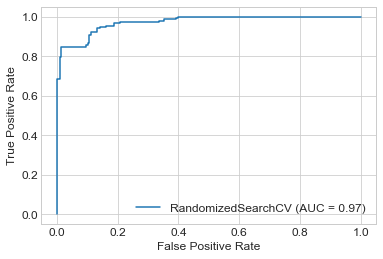

In [102]:
# Roc curve
metrics.plot_roc_curve(rs_gb, X_test, y_test)

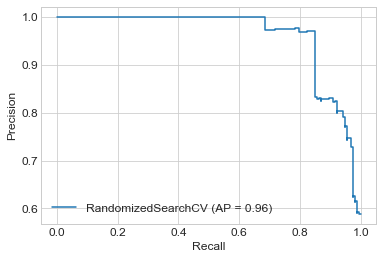

In [103]:
# Precision Recall Plot
metrics.plot_precision_recall_curve(rs_gb, X_test, y_test)

In [104]:
# Classifcations Report
classi_report = metrics.classification_report(y_test, y_preds)
print(classi_report)

              precision    recall  f1-score   support

           0       0.91      0.98      0.94       266
           1       0.97      0.82      0.89       152

    accuracy                           0.93       418
   macro avg       0.94      0.90      0.92       418
weighted avg       0.93      0.93      0.92       418



In [105]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [106]:
gender_submission.shape

(418, 2)

In [107]:
submission_report = pd.DataFrame({
    'PassengerId': test.PassengerId,
    'Survived': y_preds
})

In [108]:
submission_report.shape

(418, 2)

In [109]:
submission_report.isna().sum()

PassengerId    0
Survived       0
dtype: int64

In [110]:
submission_report.to_csv('final_submission.csv', index=False)

In [111]:
para_grid2 = {
    'loss': ['deviance'],
    'learning_rate': [1, 0.05, 0.5, 0.25, 0.1, 0.01],
    'n_estimators': [100, 250, 450, 700, 900],
    'max_depth': np.linspace(10, 32, 22),
    'min_samples_leaf': np.linspace(0.1, 0.5, 5),
    'min_samples_split': np.linspace(0.4, 1.0, 5),
    'max_features': list(range(1, train.shape[1]))
}
para_grid2

{'loss': ['deviance'],
 'learning_rate': [1, 0.05, 0.5, 0.25, 0.1, 0.01],
 'n_estimators': [100, 250, 450, 700, 900],
 'max_depth': array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
        27., 28., 29., 30., 31., 32.]),
 'min_samples_leaf': array([0.1, 0.2, 0.3, 0.4, 0.5]),
 'min_samples_split': array([0.4 , 0.55, 0.7 , 0.85, 1.  ]),
 'max_features': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]}

In [118]:
rs_gb2 = RandomizedSearchCV(
    estimator=GradientBoostingClassifier(),
    param_distributions=para_grid2,
    n_iter=100,
    cv=10,
    verbose=True,
    random_state=42,
    n_jobs=-1,
)
rs_gb2.fit(X_train, y_train)

Fitting 10 folds for each of 1000 candidates, totalling 10000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   35.1s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   57.9s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed: 11.7min
[Parallel(n_jobs=-1)]: Done 10000 out of 10000

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                        criterion='friedman_mse',
                                                        init=None,
                                                        learning_rate=0.1,
                                                        loss='deviance',
                                                        max_depth=3,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                   

In [119]:
rs_gb2.best_params_

{'n_estimators': 100,
 'min_samples_split': 0.4,
 'min_samples_leaf': 0.1,
 'max_features': 11,
 'max_depth': 3.0,
 'loss': 'deviance',
 'learning_rate': 1}

In [120]:
y_preds2 = rs_gb.predict(X_test)

In [121]:
rs_gb.score(X_test, y_test)

0.9258373205741627

**GridSearchCV**

In [117]:
# gs_gb = GridSearchCV(
#     estimator=GradientBoostingClassifier(),
#     param_grid=para_grid2,
#     cv=10,
#     verbose=True,
#     n_jobs=-1,
# )
# gs_gb.fit(X_train, y_train)

## Feature Importance

In [127]:
rs_gb2.best_estimator_.feature_importances_

array([0.00639857, 0.02155788, 0.23788757, 0.00657021, 0.00765477,
       0.07610456, 0.00313581, 0.61666745, 0.00164814, 0.        ,
       0.02237505])

In [131]:
# Defining a fuction for features

def feature_importance(model, data):
    """
    Function to show which features are most important in the model.
    ::param_model:: Which model to use?
    ::param_data:: What data to use?
    """
    fea_imp = pd.DataFrame({
        'imp': model.best_estimator_.feature_importances_,
        'col': data.columns
    })
    
    return fea_imp

In [143]:
fea_imp = feature_importance(rs_gb2, X_train)
fea_imp.sort_values('imp', inplace=True, ascending=False)
fea_imp

,imp,col
7,0.616667,Sex_male
2,0.237888,Fare
5,0.076105,Pclass_3
10,0.022375,Embarked_S
1,0.021558,Parch
4,0.007655,Pclass_2
3,0.006570,Pclass_1
0,0.006399,SibSp
6,0.003136,Sex_female
8,0.001648,Embarked_C


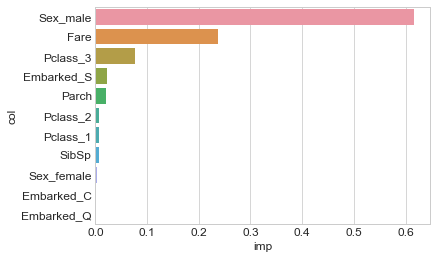

In [144]:
sns.barplot(x=fea_imp.imp, y=fea_imp.col)

## Let's Tune Decision Tree

In [147]:
# Checking Parameters
DecisionTreeClassifier().get_params

<bound method BaseEstimator.get_params of DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')>

In [157]:
# making a grid that we need to tune
dt_params = para_grid2 = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': np.linspace(1, 32, 32),
    'min_samples_leaf': np.linspace(0.1, 0.5, 5),
    'min_samples_split': np.linspace(0.4, 1.0, 5),
    'max_features': list(range(1, train.shape[1]))
}
dt_params

{'criterion': ['gini', 'entropy'],
 'splitter': ['best', 'random'],
 'max_depth': array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
        27., 28., 29., 30., 31., 32.]),
 'min_samples_leaf': array([0.1, 0.2, 0.3, 0.4, 0.5]),
 'min_samples_split': array([0.4 , 0.55, 0.7 , 0.85, 1.  ]),
 'max_features': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]}

In [158]:
# RandomizedSearchCV for tunning Decision tree
rs_dt = RandomizedSearchCV(
    DecisionTreeClassifier(),
    param_distributions=dt_params,
    cv=10,
    n_jobs=-1,
    n_iter=1000,
    verbose=True
)
rs_dt.fit(X_train, y_train)

Fitting 10 folds for each of 1000 candidates, totalling 10000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 2832 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 10000 out of 10000 | elapsed:    9.2s finished


RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features=None,
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    presort='deprecated',
                                                    random_state=None,
         

In [159]:
rs_dt.best_params_

{'splitter': 'random',
 'min_samples_split': 0.4,
 'min_samples_leaf': 0.1,
 'max_features': 5,
 'max_depth': 19.0,
 'criterion': 'gini'}

In [160]:
y_preds_dt = rs_dt.predict(X_test)

In [161]:
rs_dt.score(X_test, y_test)

1.0

In [156]:
y_preds_dt, y_test

(array([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
        1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
        1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
        1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
        1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
        0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
        1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0,
        1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
        0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
        0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 

In [163]:
rs_dt.best_estimator_.feature_importances_

array([0.       , 0.       , 0.       , 0.       , 0.       , 0.0388308,
       0.       , 0.9611692, 0.       , 0.       , 0.       ])

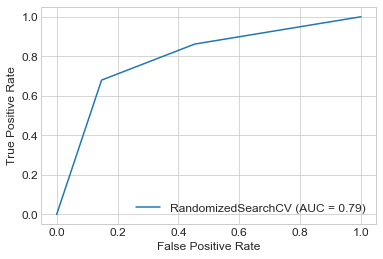

In [164]:
metrics.plot_roc_curve(rs_dt, X_train, y_train)

In [166]:
print(metrics.classification_report(y_test, y_preds_dt))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       266
           1       1.00      1.00      1.00       152

    accuracy                           1.00       418
   macro avg       1.00      1.00      1.00       418
weighted avg       1.00      1.00      1.00       418



In [170]:
gender_submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [171]:
dt_submission = pd.DataFrame({
    'PassengerId': test.PassengerId,
    'Survived': y_preds_dt
})
dt_submission

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [173]:
dt_submission.to_csv('dt_submission.csv', index=False)